# Autism Spectrum Disorder (ASD) Screening – Model Development

This notebook builds, evaluates, and compares machine learning models using the cleaned dataset. The focus is on proper validation, preventing data leakage, and reporting reliable performance metrics.

# Import Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, f1_score, auc, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

# Import and prepare the dataset

In [25]:
df = pd.read_pickle(r"C:\Users\HP\OneDrive\Documents\Data Professional\Machine Learning\Projects\ASD-prediction\ASD-cleaned")
df

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jaundice,autism,class
0,1,1,0,0,1,1,0,1,0,0,6,1,0,0,0
1,1,1,0,0,1,1,0,1,0,0,6,1,0,0,0
2,1,1,0,0,0,1,1,1,0,0,6,1,0,0,0
3,0,1,0,0,1,1,0,0,0,1,5,0,1,0,0
4,1,1,1,1,1,1,1,1,1,1,5,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,1,1,1,1,1,1,1,1,1,1,7,0,1,1,1
288,1,0,0,0,1,0,1,0,0,1,7,0,1,1,0
289,1,0,1,1,1,1,1,0,0,1,4,1,0,0,1
290,1,1,1,0,1,1,1,1,1,1,4,1,0,0,1


In [26]:
# Separate the dataset into x and y variables
x = df.drop(columns=['class'])
y = df[['class']]

In [27]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# Model Development

In [16]:
# Define the metric for cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
# Define the models
models = {
    'Logistic': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000))
    ]),

    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC())
    ]),

    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(random_state=42))
    ])
}

In [28]:
# Compare Models with Cross-Validation
results = {}

for name, model in models.items():
    scores = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy')
    results[name] = scores.mean()
    print(name, 'CV Accuracy:', scores.mean())

Logistic CV Accuracy: 1.0
SVM CV Accuracy: 0.9400555041628122
Random Forest CV Accuracy: 0.9058279370952821


In [32]:
# Check the score for individual folds
scores = cross_val_score(LogisticRegression(max_iter=1000), x_train, y_train, cv=cv)
print(scores)

[1. 1. 1. 1. 1.]


In [29]:
# Pick the Best Model
best_model_name = max(results, key=results.get)
print('Best model is:', best_model_name)

best_model = models[best_model_name]

Best model is: Logistic


In [36]:
# Fit the model on the training set
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9830508474576272
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.97      1.00      0.98        28

    accuracy                           0.98        59
   macro avg       0.98      0.98      0.98        59
weighted avg       0.98      0.98      0.98        59



Plot the AUC-ROC Curve

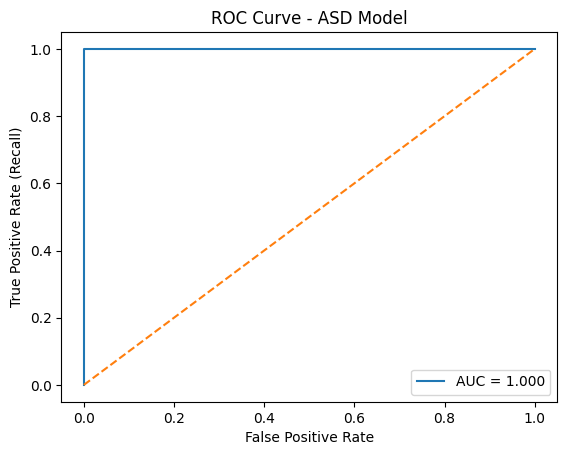

In [37]:
# Get predicted probabilities
y_probs = best_model.predict_proba(x_test)[:, 1]

# Calculate ROC values
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot the graph
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")  # random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - ASD Model")
plt.legend()
plt.show()